# HERE: go through each pixel in viable habitat of toothfish and count how many prey are "present"
# do this for the present-day and the future to check if there is "hotspots of prey loss"
# depth intervals, include drift-correction
# Fig.8 & Fig. 9 in paper

In [ ]:
#get_ipython().system(u'jupyter nbconvert --to=python plot_AGI_toothfish_present_vs_future_AGI_habitat_overlap_at_each_DEPTH_save_numbers.ipynb')

In [1]:

import xarray as xr
import numpy as np
import sys, os
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import scipy.stats as stats
from netCDF4 import Dataset
from datetime import datetime
from tqdm import tqdm

import cartopy.crs as ccrs
import cartopy
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.path as mpath
import copy
from matplotlib import colors
import seaborn as sns
from matplotlib.colors import ListedColormap


In [2]:
#-----
# based on python code provided by Anne
#-----

basepath="/pscratch/sd/c/cnissen/AGI_toothfish_project/" 
no_species=29

# Init
species_names         = [None] * no_species # empty list
species_names_        = [None] * no_species # empty list
habitat_file_names    = [None] * no_species # empty list
habitat_all = np.zeros([360,1440,no_species])

#habitat_files = Path(basepath + "all_prey_plus_toothfish/").glob('*_boolean.nc')  # updated habitat files, Nov 2022!!!!!!

# Dec 2024: recreated habitat files with Anne's scripts during review process
# test different thresholds here!
thresh = 8
habitat_files = Path(basepath + "scripts_Anne/AquaMaps/0.5deg_prob_threshold_0."+\
                     str(thresh)+"/").glob('*_boolean.nc')  

#habitat_files = Path(basepath + "share/").glob('*_boolean.nc') 
# Note: I changed name of file of Antimora_rostrata to *boolean2.nc, so that it won't be included here
for ifile,file in enumerate(habitat_files):   
    habitat_file_names[ifile]    = str(file)
    
    ff = xr.open_dataset(file)
    habitat_all[:,:,ifile] = ff['presence'].values 
    if ifile==0:
        lat  = ff['lat'].values 
        lon  = ff['lon'].values 
    ff.close()
    
    # Get the species name from the full pathname with a space between
    species_names[ifile]  = '_'.join(os.path.basename(file).split('_')[:-2]).replace('_',' ') 
    if not species_names[ifile] in ['Galiteuthis glacialis','Mesonychoteuthis hamiltoni','Kondakovia longimana']:
        species_names[ifile] = species_names[ifile][8:] # get rid of "Default" or "Reviewed"
    if species_names[ifile][0].isspace():  # get rid of white space if there is any
        species_names[ifile] = species_names[ifile][1:]
    if species_names[ifile] in ['Chionobathyscus dewitti All Suitable Habitat']:
        species_names[ifile] = species_names[ifile][0:23]
    # Get the species name from the full pathname with _ in it
    species_names_[ifile] = species_names[ifile].replace(' ','_')  #'_'.join(os.path.basename(file).split('_')[:-2]) 
    print(species_names[ifile])
    
#print(habitat_file_names)
print(species_names)
print(len(species_names),'species')
print(species_names_)

print(np.min(lat),np.max(lat),np.diff(lat)[0:4])
print(np.min(lon),np.max(lon),np.diff(lon)[0:4])


Dissostichus mawsoni
Trematomus loennbergii
Macrourus whitsoni
Galiteuthis glacialis
Chionodraco hamatus
Anotopterus vorax
Chaenodraco wilsoni
Kondakovia longimana
Cryodraco antarcticus
Muraenolepis microps
Psychroteuthis glacialis
Gymnodraco acuticeps
Amblyraja georgiana
Antarctomysis maxima
Lepidonotothen squamifrons
Mesonychoteuthis hamiltoni
Pleuragramma antarctica
Euphausia superba
Notothenia coriiceps
Trematomus lepidorhinus
Pagothenia borchgrevinki
Lycenchelys aratrirostris
Neopagetopsis ionah
Chaenocephalus aceratus
Trematomus hansoni
Chionobathyscus dewitti
Euphausia crystallorophias
Notothenia rossii
Bathyraja maccaini
['Dissostichus mawsoni', 'Trematomus loennbergii', 'Macrourus whitsoni', 'Galiteuthis glacialis', 'Chionodraco hamatus', 'Anotopterus vorax', 'Chaenodraco wilsoni', 'Kondakovia longimana', 'Cryodraco antarcticus', 'Muraenolepis microps', 'Psychroteuthis glacialis', 'Gymnodraco acuticeps', 'Amblyraja georgiana', 'Antarctomysis maxima', 'Lepidonotothen squamifron

In [3]:
#----
# Species information needed for calculation AGI
#----

# define order of species as contained in depth_min, LWa etc.
species_list = ['Cryodraco antarcticus','Neopagetopsis ionah','Trematomus lepidorhinus',\
               'Trematomus hansoni','Bathyraja maccaini','Chaenocephalus aceratus',\
               'Notothenia coriiceps','Pleuragramma antarctica','Dissostichus mawsoni',\
                'Macrourus whitsoni',\
               'Lepidonotothen squamifrons','Notothenia rossii','Muraenolepis microps',\
               'Chaenodraco wilsoni','Chionobathyscus dewitti',\
               'Galiteuthis glacialis','Mesonychoteuthis hamiltoni','Kondakovia longimana',\
               'Amblyraja georgiana','Anotopterus vorax','Antarctomysis maxima',\
               'Chionodraco hamatus','Euphausia crystallorophias','Euphausia superba','Gymnodraco acuticeps',\
               'Lycenchelys aratrirostris','Pagothenia borchgrevinki','Psychroteuthis glacialis',\
               'Trematomus loennbergii']
print(len(species_list))
# excluded the following species for now: 
# 1) Antimora rostrata: don't have the habitat file (habitat outside of SO)

# NO MAP Bathyraja eatonii	?		15	1500

# Minimum depth of occurence (meter)
depth_min     = [None] * len(species_names) # Initialize
depth_min[0]  = 90   # 'Cryodraco antarcticus'
depth_min[1]  = 20   #'Neopagetopsis ionah'
depth_min[2]  = 272    # 'Trematomus lepidorhinus'
depth_min[3]  = 6    # 'Trematomus hansoni'
depth_min[4]  = 167  # 'Bathyraja maccaini'
depth_min[5]  = 0    # 'Chaenocephalus aceratus'
depth_min[6]  = 0    # 'Notothenia coriiceps'
depth_min[7]  = 0    # 'Pleuragramma antarctica'
depth_min[8]  = 0    # 'Dissostichus mawsoni' ## Assume a wide range for toothfish (max. overlap with prey) ##
depth_min[9]  = 400  # 'Macrourus whitsoni'
depth_min[10] = 10   # 'Lepidonotothen squamifrons'
depth_min[11] = 5    # 'Notothenia rossii'
depth_min[12] = 10   # 'Muraenolepis microps'
depth_min[13] = 200  # 'Chaenodraco wilsoni'
depth_min[14] = 500  # 'Chionobathyscus dewitti'
depth_min[15] = 200   #'Galiteuthis glacialis'
depth_min[16] = 200   # 'Mesonychoteuthis hamiltoni'
depth_min[17] = 500   # 'Kondakovia longimana'
depth_min[18] = 57    # Amblyraja georgiana
depth_min[19] = 358  # Anotopterus vorax
depth_min[20] = 220 # Antarctomysis maxima
depth_min[21] = 76 # Chionodraco hamatus
depth_min[22] = 0 # Euphausia crystallorophias
depth_min[23] = 0 # Euphausia superba
depth_min[24] = 66 # Gymnodraco acuticeps
depth_min[25] = 244 # Lycenchelys aratrirostris
depth_min[26] = 0 # Pagothenia borchgrevinki
depth_min[27] = 385 # Psychroteuthis glacialis
depth_min[28] = 65 # Trematomus loennbergii
#depth_min[29] = # Trematomus eulepidotus #EXCLUDED

# Maximum depth of occurence (meter)
depth_max     = [None] * len(species_names) # Initialize
depth_max[0]  = 600  # 'Cryodraco antarcticus'
depth_max[1]  = 900  #'Neopagetopsis ionah'
depth_max[2]  = 468  # 'Trematomus lepidorhinus'
depth_max[3]  = 549  # 'Trematomus hansoni'
depth_max[4]  = 500  # 'Bathyraja maccaini'
depth_max[5]  = 770  # 'Chaenocephalus aceratus'
depth_max[6]  = 550  # 'Notothenia coriiceps'
depth_max[7]  = 1000 # 'Pleuragramma antarctica'
depth_max[8]  = 2210   # 'Dissostichus mawsoni' ## Assume a wide range for toothfish (max. overlap with prey) ##
depth_max[9]  = 3185 # 'Macrourus whitsoni'
depth_max[10] = 900  # 'Lepidonotothen squamifrons'
depth_max[11] = 350 # 'Notothenia rossii'
depth_max[12] = 1600 # 'Muraenolepis microps'
depth_max[13] = 800  # 'Chaenodraco wilsoni'
depth_max[14] = 2000 # 'Chionobathyscus dewitti'
depth_max[15] = 2500   #'Galiteuthis glacialis'
depth_max[16] =  600  # 'Mesonychoteuthis hamiltoni'
depth_max[17] = 2000   # 'Kondakovia longimana'
depth_max[18] = 173    # Amblyraja georgiana
depth_max[19] = 1059 # Anotopterus vorax
depth_max[20] = 440 # Antarctomysis maxima
depth_max[21] = 271 # Chionodraco hamatus
depth_max[22] = 650 # Euphausia crystallorophias
depth_max[23] = 600 # Euphausia superba
depth_max[24] = 247 # Gymnodraco acuticeps
depth_max[25] = 376 # Lycenchelys aratrirostris
depth_max[26] = 30 # Pagothenia borchgrevinki
depth_max[27] = 610 # Psychroteuthis glacialis
depth_max[28] = 832 # Trematomus loennbergii
#depth_max[29] = # Trematomus eulepidotus EXCLUDED


29


In [4]:
#----
# get indices of depth levels of species
#----

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

file_mesh = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/Mesh_ancillary_information_v20220919.nc'
data_levels = xr.open_dataset(file_mesh)
depth    = data_levels['depth'].values # 88 levels
lon      = data_levels['lon'].values 
lat      = data_levels['lat'].values 
mask        = data_levels['mask_vol'].values
data_levels.close()

index_min_depth     = [None] * len(species_names) # Initialize
index_max_depth     = [None] * len(species_names) # Initialize

for i,name in enumerate(species_names):
    # Note Cara: order of entries in depth_min etc. is not alphabetical!!!!
    # here, I have adapted the index from "i" to "iii" to read in the correct depth ranges
    # for the current species
    iii = species_list.index(species_names[i]) # get index of current species as contained in depth_min etc.
    index_min_depth[i] = find_nearest(depth,depth_min[iii])
    index_max_depth[i] = find_nearest(depth,depth_max[iii])
    print(i,species_names[i],iii,species_list[iii])
    # now, index_min_depth should contain the correct values according to alphabetical order as looped over
    # NOTE: given how python is indexing, I think I then need to index over index_min_depth:index_max_depth+1
    # (was index_min_depth:index_max_depth before)
    

0 Dissostichus mawsoni 8 Dissostichus mawsoni
1 Trematomus loennbergii 28 Trematomus loennbergii
2 Macrourus whitsoni 9 Macrourus whitsoni
3 Galiteuthis glacialis 15 Galiteuthis glacialis
4 Chionodraco hamatus 21 Chionodraco hamatus
5 Anotopterus vorax 19 Anotopterus vorax
6 Chaenodraco wilsoni 13 Chaenodraco wilsoni
7 Kondakovia longimana 17 Kondakovia longimana
8 Cryodraco antarcticus 0 Cryodraco antarcticus
9 Muraenolepis microps 12 Muraenolepis microps
10 Psychroteuthis glacialis 27 Psychroteuthis glacialis
11 Gymnodraco acuticeps 24 Gymnodraco acuticeps
12 Amblyraja georgiana 18 Amblyraja georgiana
13 Antarctomysis maxima 20 Antarctomysis maxima
14 Lepidonotothen squamifrons 10 Lepidonotothen squamifrons
15 Mesonychoteuthis hamiltoni 16 Mesonychoteuthis hamiltoni
16 Pleuragramma antarctica 7 Pleuragramma antarctica
17 Euphausia superba 23 Euphausia superba
18 Notothenia coriiceps 6 Notothenia coriiceps
19 Trematomus lepidorhinus 2 Trematomus lepidorhinus
20 Pagothenia borchgrevink

In [5]:
#---
# construct topo mask (to separate shelves from open ocean)
#---

print(mask.shape)
#print(mask)

topo = np.nan*np.ones([mask.shape[1],mask.shape[2]])
for mm in range(0,mask.shape[1]):
    for nn in range(0,mask.shape[2]):
        aux = mask[:,mm,nn]
        if np.sum(aux)>0:
            #print(mm,nn,aux)
            #print(levels[aux==1][-1])
            topo[mm,nn] = depth[aux==1][-1]
    
print('Min/Max topo:',np.nanmin(topo),np.nanmax(topo))



(88, 360, 1440)
Min/Max topo: 203.5 3185.0


In [6]:
#-----
# calculate AGI from annual mean fields
#-----
print('thresh:',thresh)

# constants
d = 0.7 # n.d.; metabolic scaling coefficient
j1 = 4500 # K; "Anabolism activation energy divided by Boltzmann constant" (Clarke2021)
j2 = 8000 # K; "Catabolism activation energy divided by Boltzmann constant" (Clarke2021)
j_diff = j2-j1
# from Clarke2021: "Somatic (or biomass) growth can be expressed as the difference between anabolism and catabolism"

#---
# load AGIcrit, Tpref, O2thresh
#---

# Init
AGI_crit = [None] * no_species # empty list
o2thresh = [None] * no_species # empty list
TPref    = [None] * no_species # empty list

based_on_monthly_clim_AGIcrit = True # if False, use AGIcrit calculated based on annual mean climatology

# AGIcrit 
for ii in range(0,len(species_names)):
    if based_on_monthly_clim_AGIcrit:
        file = 'AGIcrit_'+species_names_[ii]+'_based_on_monthly_clim_1995_2014_threshold_0.'+str(thresh)+'.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/'+file)
    else:
        file = 'AGIcrit_'+species_names_[ii]+'_based_on_annual_clim_1995_2014.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/based_on_annual/'+file)
    AGI_crit[ii]        = ff['AGIcrit'].values[0]
    ff.close()
    
# o2thresh  
for ii in range(0,len(species_names)):
    if based_on_monthly_clim_AGIcrit:
        file = 'o2thresh_'+species_names_[ii]+'_based_on_monthly_clim_1995_2014_threshold_0.'+str(thresh)+'.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/'+file)
    else:
        file = 'o2thresh_'+species_names_[ii]+'_based_on_annual_clim_1995_2014.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/based_on_annual/'+file)
    o2thresh[ii]        = ff['o2thresh'].values[0]
    ff.close()
    
# TPref 
for ii in range(0,len(species_names)):
    if based_on_monthly_clim_AGIcrit:
        file = 'Tpref_'+species_names_[ii]+'_based_on_monthly_clim_1995_2014_threshold_0.'+str(thresh)+'.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/'+file)
    else:
        file = 'Tpref_'+species_names_[ii]+'_based_on_annual_clim_1995_2014.nc'
        ff     = xr.open_dataset(basepath+'new_thresholds/based_on_annual/'+file)
    TPref[ii]        = ff['Tpref'].values[0]
    ff.close()


thresh: 8


In [7]:
print(AGI_crit)
print(basepath)

[1.3514082, 1.3325053, 1.3300396, 1.9235835, 1.3109272, 1.3179287, 1.3467731, 1.2658287, 1.3196465, 1.294982, 1.220041, 1.3228862, 1.3680505, 1.1893058, 1.1999654, 1.3957235, 1.3390918, 1.3224404, 1.1254811, 1.3324872, 1.4016529, 1.3302829, 1.3416198, 1.2422483, 1.2402405, 1.3705868, 1.3174027, 1.3814464, 1.3267548]
/pscratch/sd/c/cnissen/AGI_toothfish_project/


In [8]:
#-----
# PRESENT-DAY
# calculate AGI based on annual fields
# part I: load pO2 & t_insitu fields
#-----

which_sim = 'simAssp585' # for present-day, keep this as simAssp585! 
#path1 = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/'+which_sim+'_reduced/'
path1 = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/ARCHIVE_AGI/' # new path for repeating calculation during review process

#----
# PRESENT-DAY
#----

year_list1 = np.arange(1995,2014+1,1)

for yy in range(0,len(year_list1)):
    year1 = year_list1[yy]
    print('Load year ',year1)
    
    # pO2 data (mbar)
    file_pO2  = path1+'/pO2_fesom_'+which_sim+'_'+str(year1)+'0101_v2.nc'
    data_pO2   = xr.open_dataset(file_pO2)
    a1 = data_pO2['pO2'].values
    a1 = np.ma.masked_where(a1<0,a1)
    print('Min/Max pO2:',np.nanmin(a1),np.nanmax(a1))
    if yy==0:
        pO2_1      = a1 #data_pO2['pO2'].values
    else:
        pO2_1      = pO2_1+ a1 #data_pO2['pO2'].values
    data_pO2.close()
    del a1

    # T insitu (deg C)
    file_t_insitu   = path1+'/t_insitu_fesom_'+which_sim+'_'+str(year1)+'0101_v2.nc'
    data_t_insitu   = xr.open_dataset(file_t_insitu)
    a1 = data_t_insitu['t_insitu'].values
    a1 = np.ma.masked_where(a1<-3.0,a1)
    print('Min/Max t_insitu:',np.nanmin(a1),np.nanmax(a1))
    #print('Min/Max t_insitu:',np.min(data_t_insitu['t_insitu'].values),np.max(data_t_insitu['t_insitu'].values))
    if yy==0:
        t_insitu_1        = a1 #data_t_insitu['t_insitu'].values
    else:
        t_insitu_1        = t_insitu_1+ a1 #data_t_insitu['t_insitu'].values
    data_t_insitu.close()
    del a1
    
# calculate climatology
t_insitu_1 = t_insitu_1/len(year_list1)
pO2_1      = pO2_1/len(year_list1)
print('')
print('Min/Max t_insitu:',np.nanmin(t_insitu_1),np.nanmax(t_insitu_1))
print('Min/Max pO2:',np.nanmin(pO2_1),np.nanmax(pO2_1))
    
print('done')


Load year  1995
Min/Max pO2: 4.207563 225.77884
Min/Max t_insitu: -2.571443 15.545197
Load year  1996
Min/Max pO2: 2.8013957 225.59848
Min/Max t_insitu: -2.575366 14.551913
Load year  1997
Min/Max pO2: 1.8041228 225.43907
Min/Max t_insitu: -2.5624118 15.000496
Load year  1998
Min/Max pO2: 0.027826557 225.30064
Min/Max t_insitu: -2.5636892 15.028485
Load year  1999
Min/Max pO2: 1.8957909 225.04358
Min/Max t_insitu: -2.5640612 14.615901
Load year  2000
Min/Max pO2: 9.454568 224.61386
Min/Max t_insitu: -2.5593815 15.245595
Load year  2001
Min/Max pO2: 3.726922 224.15968
Min/Max t_insitu: -2.5575552 15.217681
Load year  2002
Min/Max pO2: 2.2234223 223.76306
Min/Max t_insitu: -2.5549266 14.752597
Load year  2003
Min/Max pO2: 2.194433 224.76065
Min/Max t_insitu: -2.5629275 15.570725
Load year  2004
Min/Max pO2: 2.6431694 229.60274
Min/Max t_insitu: -2.5545547 16.359056
Load year  2005
Min/Max pO2: 1.7453376 229.03206
Min/Max t_insitu: -2.5574455 14.253276
Load year  2006
Min/Max pO2: 3.34010

In [9]:
#-----
# calculate AGI based on annual fields
# part I: load pO2 & t_insitu fields
#-----

# the drift-corrected files are in folders called ssp585_reduced, ssp370_reduced etc. (simAssp585 has the non-drift-corrected files)
which_sim   = 'ssp585' 
which_drift = '2091_2100' # 2081_2100, 2091_2100, 2098_2100, 2090_2099

# example file name for drift-corrected files: t_insitu_fesom_ssp245_20910101_monthly_drift_corrected_2090_2099_minus_1995_2014_v2.nc
drift_corr ='monthly_drift_corrected_'+which_drift+'_minus_1995_2014_v2' 

# ORIGINAL path
#path1 = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/'+which_sim+'_reduced/'

# Dec 2024: path used in review process (I had to re-upload the files and put them all into a single folder)
path1 = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/ARCHIVE_AGI/'

#which_sim = 'simAssp585'
#path1 = '/pscratch/sd/c/cnissen/files_toothfish_project_AGI/'+which_sim+'_reduced/'

#----
# FUTURE
#----

year_list2 = np.arange(int(which_drift[0:4]),int(which_drift[5:])+1,1)

for yy in range(0,len(year_list2)):
    year2 = year_list2[yy]
    print('Load year ',year2)
    
    # pO2 data (mbar)
    file_pO2  = path1+'/pO2_fesom_'+which_sim+'_'+str(year2)+'0101_'+drift_corr+'.nc'
    data_pO2   = xr.open_dataset(file_pO2)
    if yy==0:
        print('Load depth levels')
        depths = data_pO2['depth'].values
    a1 = data_pO2['pO2'].values
    a1 = np.ma.masked_where(a1<0,a1)
    print('Min/Max pO2:',np.nanmin(a1),np.nanmax(a1))
    if yy==0:
        pO2_2      = a1 #data_pO2['pO2'].values
    else:
        pO2_2      = pO2_2+ a1 #data_pO2['pO2'].values
    data_pO2.close()
    del a1

    # T insitu (deg C)
    file_t_insitu   = path1+'/t_insitu_fesom_'+which_sim+'_'+str(year2)+'0101_'+drift_corr+'.nc'
    data_t_insitu   = xr.open_dataset(file_t_insitu)
    a1 = data_t_insitu['t_insitu'].values
    a1 = np.ma.masked_where(a1<-3.0,a1)
    print('Min/Max t_insitu:',np.nanmin(a1),np.nanmax(a1))
    #print('Min/Max t_insitu:',np.min(data_t_insitu['t_insitu'].values),np.max(data_t_insitu['t_insitu'].values))
    if yy==0:
        t_insitu_2        = a1 #data_t_insitu['t_insitu'].values
    else:
        t_insitu_2        = t_insitu_2+ a1 #data_t_insitu['t_insitu'].values
    data_t_insitu.close()
    del a1

# calculate climatology
t_insitu_2 = t_insitu_2/len(year_list2)
pO2_2      = pO2_2/len(year_list2)
    
# volume data 
data_vol   = xr.open_dataset(file_mesh)
vol        = data_vol['volume']
data_vol.close()

#print(vol.shape)
#print(t_insitu_2.shape)
#print(pO2_2.shape)

print('')
print('Min/Max t_insitu:',np.nanmin(t_insitu_2),np.nanmax(t_insitu_2))
print('Min/Max pO2:',np.nanmin(pO2_2),np.nanmax(pO2_2))

# to be checked: without this step, temp minimum is -41 or so for future... why?
#t_insitu_1[t_insitu_1<-5]=np.nan
#t_insitu_2[t_insitu_2<-5]=np.nan
#print('min/max t_insitu_2:',np.nanmin(t_insitu_2),np.nanmax(t_insitu_2))
#t_insitu_1 = np.ma.masked_where(t_insitu_1<-40,t_insitu_1)
#t_insitu_2 = np.ma.masked_where(t_insitu_2<-40,t_insitu_2)
##print('min/max t_insitu_1:',np.nanmin(t_insitu_1),np.nanmax(t_insitu_1))
#print('min/max t_insitu_2:',np.nanmin(t_insitu_2),np.nanmax(t_insitu_2))

print('done')


Load year  2091
Load depth levels
Min/Max pO2: 0.18407242 245.66891
Min/Max t_insitu: -2.5228913 17.88519
Load year  2092
Min/Max pO2: 0.18615732 246.0024
Min/Max t_insitu: -2.5127351 17.922821
Load year  2093
Min/Max pO2: 0.2095166 242.58719
Min/Max t_insitu: -2.7079659 17.464113
Load year  2094
Min/Max pO2: 0.21596994 252.32352
Min/Max t_insitu: -2.522755 18.096907
Load year  2095
Min/Max pO2: 0.21790534 244.46132
Min/Max t_insitu: -2.552226 17.449821
Load year  2096
Min/Max pO2: 0.22117928 249.26617
Min/Max t_insitu: -2.5628629 18.667217
Load year  2097
Min/Max pO2: 0.22600251 248.33086
Min/Max t_insitu: -2.6080208 17.687935
Load year  2098
Min/Max pO2: 0.20842572 248.31505
Min/Max t_insitu: -2.5353906 17.82436
Load year  2099
Min/Max pO2: 0.20978902 244.02168
Min/Max t_insitu: -2.5157914 18.47154
Load year  2100
Min/Max pO2: 0.20297492 247.70912
Min/Max t_insitu: -2.514549 18.517756

Min/Max t_insitu: -2.5108533 17.641241
Min/Max pO2: 0.21230969 240.27682
done


In [10]:
#----
# functions
#----

def get_mask_viable_habitat(i,hab_field,vol,pO2,t_insitu,index_min_depth,index_max_depth,\
                                    species_list,species_names,TPref,o2thresh,AGI_crit,j_diff,mask):
    # NOTE: "mask" is 2D field; can be an MPA or the whole Southern Ocean (array of ones in this case)
    
    # turn mask into 3D
    mask3D = np.tile(mask,[88,1,1])
    #mask3D = mask3D[index_min_depth[i]:index_max_depth[i]+1,:,:] # select depth levels of interest
    
    # set mask outside of depth range to zero
    if index_min_depth[i]>0:
        mask3D[0:index_min_depth[i],:,:] = 0  # this said "mask3D[0:index_min_depth[i]:,:] = 0" before -> so shallow depth levels were not correctly masked?
    mask3D[index_max_depth[i]:,:,:] = 0
    
    ### select the data/volume over the relevant depth range, correct with habitat array
    # NOTE: index_min_depth[i]:index_max_depth[i]    or.    index_min_depth[i]:index_max_depth[i]+1   ?
    vol_inhabitat = (vol.values[:,:,:]*hab_field*mask3D) 
    dataout1      = (pO2[:,:,:]*hab_field*mask3D)
    dataout2      = (t_insitu[:,:,:]*hab_field*mask3D)
    #print(dataout1.shape) # depth x lat x lon
    
    # CHECK: if habitat starts at subsurface, fields should not containt any numbers >0 at the surface
    print('index_min_depth[i]',index_min_depth[i],np.nanmax(vol_inhabitat[0,:,:]),np.nanmax(dataout1[0,:,:]),np.nanmax(dataout2[0,:,:]))

    # use all months -> don't "ravel" here to keep the depths x lat x lon format
    dataout1b = dataout1[:,:,:] #.ravel() # pO2
    dataout2b = dataout2[:,:,:] #.ravel() # temp
    # make sure volume array has dimensions months x depths x lat x lon before applying ravel()
    vol_inhabitat_b = np.copy(vol_inhabitat) #.ravel() #np.tile(vol_inhabitat,(12,1,1,1)).ravel() 
    
    dataout2b       = np.ma.masked_where(np.isnan(dataout1b),dataout2b) # every available node
    vol_inhabitat_b = np.ma.masked_where(np.isnan(dataout1b),vol_inhabitat_b)
    dataout1b       = np.ma.masked_where(np.isnan(dataout1b),dataout1b)
    
    dataout2b       = np.ma.masked_where(dataout1b==0,dataout2b) # every available node
    vol_inhabitat_b = np.ma.masked_where(dataout1b==0,vol_inhabitat_b)
    dataout1b       = np.ma.masked_where(dataout1b==0,dataout1b)
    
    vol_weights = vol_inhabitat_b/np.nansum(vol_inhabitat_b)
    
    # order of species in W, Winf etc not the same as in this i-loop!
    # correct for that here (same was done for index_min_depth and index_max_depth)
    iii = species_list.index(species_names[i])
    
    #------
    # get Tpref & O2thresh -> see plot_AGI_toothfish_TPref_O2thresh_save_as_netcdf.ipynb
    #   Tpref: 50th percentile in habitat (volume weighted)
    #   O2thresh: 10th percentile in habitat (volume weighted)
    tpref_species    = TPref[i]
    o2thresh_species = o2thresh[i]   
    #------
    
    #----
    # calculate AGIcrit: 10th percentile in habitat (volume wieghted)
    
    #w_ratio = (W[iii]**(1-d))/(Winf[iii]**(1-d))
    # UPDATE Jan 2023: adapt calculation of AGI to what is in Anne's paper (W, W_inf etc not needed anymore)
    w_ratio = ((1./3.)**(1-d))
    a1 = np.exp((j_diff/(tpref_species+273.15)) - (j_diff/(dataout2b+273.15)))
    
    AGI = dataout1b/(o2thresh_species*w_ratio*a1)
    
    #res = weighted_quantile(AGI, [0.1], sample_weight=vol_weights)
    
    mask_habitat = np.zeros_like(AGI) 
    
    #---
    AGI[AGI.mask==True]=-999 # DOES THIS line change the problem with identifying prey at a depth level where it shouldn't be?
    ind_hab = np.where(AGI>AGI_crit[i]) # if AGI contains masked cells, these will be interpreted as >1 here!!!!
    #---
    mask_habitat[ind_hab] = 1
    mask_habitat[mask_habitat.mask==True]=0
    #print('np.nanmax(AGI[0,:,:])',np.nanmax(AGI[0,:,:]))
    
    # CHECK: if habitat starts at subsurface, fields should not containt any numbers >0 at the surface
    print('index_min_depth[i], np.nanmax(mask_habitat[0,:,:])',index_min_depth[i],np.nanmax(mask_habitat[0,:,:]))

    return mask_habitat,vol_inhabitat_b
    

In [11]:
print(index_min_depth)

[0, 7, 29, 19, 9, 27, 19, 34, 10, 2, 29, 8, 7, 20, 2, 19, 0, 0, 0, 23, 0, 21, 3, 0, 1, 34, 0, 1, 16]


In [12]:
#----
# get mask with viable habitat for toothfish and all prey
#----
#----
# what do I want to calculate?
#----
# at each grid cell of the toothfish habitat, count how many species are present
#   do this for present-day and future
#   are there any regions/depth levels that are hotspots of prey loss?
#   are there any regions/depth levels that have no prey left even though the habitat is still viable for the toothfish?
#

today = datetime.today()

save_to_netcdf = True

# Note: keep order as is. Order is hard-coded when writing data to netcdf file!!
subregions = ['wholeSO','RossSea','WeddellSea','AntarcticPeninsula','Orkney',\
             'EastAntarctica1','EastAntarctica2','EastAntarctica3']
#subregions = ['all_shelves','all_openOcean']
    
if which_sim in ['simAssp585']:
    color_future = 'darkblue'
elif which_sim in ['simAssp370']:
    color_future = 'mediumturquoise'
elif which_sim in ['simAssp245']:
    color_future = 'cornflowerblue'
elif which_sim in ['simAssp126']:
    color_future = 'mediumpurple'
    
mask_all = np.ones([t_insitu_1.shape[1],t_insitu_1.shape[2]])
mask_all[np.isnan(mask_all)]=0
    
# get toothfish habitat
i_tf = species_names.index("Dissostichus mawsoni")
print(i_tf,species_names[i_tf])
#print(habitat_file_names[i_tf])
    
### Get the in-habitat data for each species over the relevant depth range ###
file_habitat = habitat_file_names[i_tf]
data_hab     = xr.open_dataset(file_habitat) # 2D habitat presence/absence data (1 for present or 0 for absent)
# make sure the habitat field has dimensions depth x lat x lon before applying it to the respective fields
num_depth = 88 #len(np.arange(index_min_depth[i_tf],index_max_depth[i_tf]+1,1)) 
hab_field = np.tile(data_hab['presence'].values,(num_depth,1,1))
data_hab.close()

# present-day
#print ('get toothfish habitat, present-day')
mask_habitat_toothfish_1,vol_1 = get_mask_viable_habitat(i_tf,hab_field,vol,pO2_1,t_insitu_1,\
                                                    index_min_depth,index_max_depth,\
                                     species_list,species_names,TPref,o2thresh,AGI_crit,\
                                                    j_diff,mask_all)
# future
#print ('get toothfish habitat, future')
mask_habitat_toothfish_2,vol_2 = get_mask_viable_habitat(i_tf,hab_field,vol,pO2_2,t_insitu_2,\
                                        index_min_depth,index_max_depth,\
                                    species_list,species_names,TPref,o2thresh,AGI_crit,\
                                        j_diff,mask_all)
del vol_1,vol_2
    
# get masks for all prey species
mask_habitat_prey_1 = np.zeros([len(species_names)-1,mask_habitat_toothfish_1.shape[0],mask_habitat_toothfish_1.shape[1],mask_habitat_toothfish_1.shape[2]])
mask_habitat_prey_2 = np.zeros([len(species_names)-1,mask_habitat_toothfish_1.shape[0],mask_habitat_toothfish_1.shape[1],mask_habitat_toothfish_1.shape[2]])
counter = 0
for i in tqdm(range(0,len(species_names))):
    if not species_names[i] in ["Dissostichus mawsoni"]:
        #print(i,species_names[i])
        
        ### Get the in-habitat data for each species over the relevant depth range ###
        file_habitat = habitat_file_names[i]
        data_hab     = xr.open_dataset(file_habitat) # 2D habitat presence/absence data (1 for present or 0 for absent)
        # make sure the habitat field has dimensions depth x lat x lon before applying it to the respective fields
        num_depth = 88 #len(np.arange(index_min_depth[i],index_max_depth[i]+1,1)) 
        hab_field = np.tile(data_hab['presence'].values,(num_depth,1,1))
        data_hab.close()

        # present-day
        #print ('get habitat, present-day')
        mask_habitat_prey_1[counter,:,:,:],vol_prey_1 = get_mask_viable_habitat(i,hab_field,vol,pO2_1,t_insitu_1,\
                                            index_min_depth,index_max_depth,\
                                            species_list,species_names,TPref,o2thresh,AGI_crit,\
                                            j_diff,mask_all)
        # future
        #print ('get habitat, future')
        mask_habitat_prey_2[counter,:,:,:],vol_prey_2 = get_mask_viable_habitat(i,hab_field,vol,pO2_2,t_insitu_2,\
                                            index_min_depth,index_max_depth,\
                                            species_list,species_names,TPref,o2thresh,AGI_crit,\
                                            j_diff,mask_all)
        del vol_prey_1,vol_prey_2
        counter = counter+1    
    
print('done')
    

0 Dissostichus mawsoni
index_min_depth[i] 0 558466496.0 202.7892303466797 1.575987458229065
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 0 558466496.0 207.5094757080078 3.9576268196105957
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0


  0%|          | 0/29 [00:00<?, ?it/s]

index_min_depth[i] 7 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 7 0.0
index_min_depth[i] 7 0.0 0.0 -0.0


  7%|▋         | 2/29 [00:18<04:07,  9.18s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 7 0.0
index_min_depth[i] 29 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 29 0.0
index_min_depth[i] 29 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 29 0.0


 10%|█         | 3/29 [00:36<05:35, 12.91s/it]

index_min_depth[i] 19 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 19 0.0
index_min_depth[i] 19 0.0 0.0 -0.0


 14%|█▍        | 4/29 [00:54<06:11, 14.86s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 19 0.0
index_min_depth[i] 9 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 9 0.0
index_min_depth[i] 9 0.0 0.0 -0.0


 17%|█▋        | 5/29 [01:12<06:24, 16.02s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 9 0.0
index_min_depth[i] 27 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 27 0.0
index_min_depth[i] 27 0.0 0.0 -0.0


 21%|██        | 6/29 [01:31<06:25, 16.78s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 27 0.0
index_min_depth[i] 19 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 19 0.0
index_min_depth[i] 19 0.0 0.0 -0.0


 24%|██▍       | 7/29 [01:49<06:19, 17.25s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 19 0.0
index_min_depth[i] 34 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 34 0.0
index_min_depth[i] 34 0.0 0.0 -0.0


 28%|██▊       | 8/29 [02:07<06:08, 17.54s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 34 0.0
index_min_depth[i] 10 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 10 0.0
index_min_depth[i] 10 0.0 0.0 -0.0


 31%|███       | 9/29 [02:26<06:00, 18.01s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 10 0.0
index_min_depth[i] 2 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 2 0.0
index_min_depth[i] 2 0.0 0.0 -0.0


 34%|███▍      | 10/29 [02:44<05:44, 18.11s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 2 0.0
index_min_depth[i] 29 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 29 0.0
index_min_depth[i] 29 0.0 0.0 -0.0


 38%|███▊      | 11/29 [03:03<05:26, 18.17s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 29 0.0
index_min_depth[i] 8 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 8 0.0
index_min_depth[i] 8 0.0 0.0 -0.0


 41%|████▏     | 12/29 [03:21<05:11, 18.30s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 8 0.0
index_min_depth[i] 7 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 7 0.0
index_min_depth[i] 7 0.0 0.0 -0.0


 45%|████▍     | 13/29 [03:40<04:54, 18.41s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 7 0.0
index_min_depth[i] 20 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 20 0.0
index_min_depth[i] 20 0.0 0.0 -0.0


 48%|████▊     | 14/29 [03:58<04:36, 18.41s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 20 0.0
index_min_depth[i] 2 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 2 0.0
index_min_depth[i] 2 0.0 0.0 -0.0


 52%|█████▏    | 15/29 [04:17<04:17, 18.42s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 2 0.0
index_min_depth[i] 19 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 19 0.0
index_min_depth[i] 19 0.0 0.0 -0.0


 55%|█████▌    | 16/29 [04:35<03:58, 18.32s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 19 0.0
index_min_depth[i] 0 480506496.0 195.58233642578125 0.07339541614055634
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 0 480506496.0 206.7949981689453 1.3117849826812744


 59%|█████▊    | 17/29 [04:53<03:40, 18.34s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 0 605443520.0 208.6111602783203 5.519413471221924
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 0 605443520.0 211.7447509765625 8.944448471069336
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0


 62%|██████▏   | 18/29 [05:12<03:22, 18.40s/it]

index_min_depth[i] 0 650161984.0 210.4605255126953 5.5517449378967285
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 0 650161984.0 211.73123168945312 7.4556169509887695


 66%|██████▌   | 19/29 [05:31<03:06, 18.61s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 23 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 23 0.0
index_min_depth[i] 23 0.0 0.0 -0.0


 69%|██████▉   | 20/29 [05:50<02:47, 18.66s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 23 0.0
index_min_depth[i] 0 473188704.0 194.07420349121094 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 0 473188704.0 202.42108154296875 0.9594789743423462


 72%|███████▏  | 21/29 [06:08<02:28, 18.62s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 21 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 21 0.0
index_min_depth[i] 21 0.0 0.0 -0.0


 76%|███████▌  | 22/29 [06:27<02:10, 18.59s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 21 0.0
index_min_depth[i] 3 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 3 0.0
index_min_depth[i] 3 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 3 0.0


 79%|███████▉  | 23/29 [06:45<01:51, 18.60s/it]

index_min_depth[i] 0 578865024.0 209.18460083007812 3.9356465339660645
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 0 578865024.0 209.43704223632812 6.381229877471924


 83%|████████▎ | 24/29 [07:04<01:32, 18.54s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 1 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 1 0.0
index_min_depth[i] 1 0.0 0.0 -0.0


 86%|████████▌ | 25/29 [07:22<01:14, 18.56s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 1 0.0
index_min_depth[i] 34 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 34 0.0
index_min_depth[i] 34 0.0 0.0 -0.0


 90%|████████▉ | 26/29 [07:41<00:55, 18.52s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 34 0.0
index_min_depth[i] 0 530675584.0 201.54811096191406 1.3065240383148193
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 0 530675584.0 207.0789031982422 3.676344394683838


 93%|█████████▎| 27/29 [07:59<00:37, 18.52s/it]

index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 0 1.0
index_min_depth[i] 1 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 1 0.0
index_min_depth[i] 1 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 1 0.0


 97%|█████████▋| 28/29 [08:19<00:18, 18.73s/it]

index_min_depth[i] 16 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 16 0.0
index_min_depth[i] 16 0.0 0.0 -0.0
index_min_depth[i], np.nanmax(mask_habitat[0,:,:]) 16 0.0


100%|██████████| 29/29 [08:39<00:00, 17.90s/it]

done


In [13]:
#---
# get max. number of prey species at each depth level -> based on depth range of each species
#---

depth[0] = 0 #-1*depth[0]

# depth_min, depth_max are sorted according to "species_list"
# -> make sure to choose the correct indices!

max_num_prey = np.zeros([len(depth)])
for dd in range(0,len(depth)):
    for nn in range(0,len(species_names)):
        if not species_names[nn] in ["Dissostichus mawsoni"]:
            ind_ss = species_list.index(species_names[nn])
            #print(depth[dd],depth[dd+1],depth_min[nn],depth_max[nn])
            if depth[dd]==np.max(depth):
                if depth_max[ind_ss]>depth[dd]:
                    #print(nn,species_names[nn],index_min_depth[nn])
                    max_num_prey[dd] = max_num_prey[dd]+1
            else:
                x = range(int(depth[dd]),int(depth[dd+1]))
                y = range(depth_min[ind_ss],depth_max[ind_ss])
                xs = set(x)
                if len(xs.intersection(y))>0: # if there is any overlap in ranges
                    #print(nn,species_names[nn],depth_min[ind_ss])
                    max_num_prey[dd] = max_num_prey[dd]+1
                #print(xs.intersection(y),len(xs.intersection(y)))
                
# OLD VERSION
old_code = False
if old_code:
    max_num_prey = np.zeros([len(depth)])
    for dd in range(0,1):#len(depth)):
        for nn in range(0,len(species_names)):
            if not species_names[nn] in ["Dissostichus mawsoni"]:
                #print(depth[dd],depth[dd+1],depth_min[nn],depth_max[nn])
                if depth[dd]==np.max(depth):
                    if depth_max[nn]>depth[dd]:
                        print(nn,species_names[nn],index_min_depth[nn])
                        max_num_prey[dd] = max_num_prey[dd]+1
                else:
                    x = range(int(depth[dd]),int(depth[dd+1]))
                    y = range(depth_min[nn],depth_max[nn])
                    xs = set(x)
                    if len(xs.intersection(y))>0: # if there is any overlap in ranges
                        print(nn,species_names[nn],depth_min[nn])
                        max_num_prey[dd] = max_num_prey[dd]+1
                    #print(xs.intersection(y),len(xs.intersection(y)))
                
print(max_num_prey)
print(depth_min)


[ 6.  8. 10. 11. 10. 10. 11. 13. 14. 14. 15. 15. 15. 15. 15. 15. 16. 15.
 18. 18. 19. 20. 19. 19. 19. 19. 19. 19. 20. 20. 20. 20. 19. 18. 20. 19.
 19. 17. 17. 17. 13. 13. 12. 12. 12. 12. 12. 12. 11. 10. 10.  9.  9.  9.
  7.  7.  7.  6.  6.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  4.  4.  4.  4.  4.  4.  2.  2.  2.  2.  2.  1.  1.  1.  1.  0.]
[90, 20, 272, 6, 167, 0, 0, 0, 0, 400, 10, 5, 10, 200, 500, 200, 200, 500, 57, 358, 220, 76, 0, 0, 66, 244, 0, 385, 65]


In [14]:
print(species_names)

['Dissostichus mawsoni', 'Trematomus loennbergii', 'Macrourus whitsoni', 'Galiteuthis glacialis', 'Chionodraco hamatus', 'Anotopterus vorax', 'Chaenodraco wilsoni', 'Kondakovia longimana', 'Cryodraco antarcticus', 'Muraenolepis microps', 'Psychroteuthis glacialis', 'Gymnodraco acuticeps', 'Amblyraja georgiana', 'Antarctomysis maxima', 'Lepidonotothen squamifrons', 'Mesonychoteuthis hamiltoni', 'Pleuragramma antarctica', 'Euphausia superba', 'Notothenia coriiceps', 'Trematomus lepidorhinus', 'Pagothenia borchgrevinki', 'Lycenchelys aratrirostris', 'Neopagetopsis ionah', 'Chaenocephalus aceratus', 'Trematomus hansoni', 'Chionobathyscus dewitti', 'Euphausia crystallorophias', 'Notothenia rossii', 'Bathyraja maccaini']


In [15]:
#---
# get max number of prey in depth intervals
#---

# second version (guided by environmental change in toothfish habitat)
#depth_list1 = [0,  400,700,1000]
#depth_list2 = [400,700,1000,3500]

depth_list1 = [0,  100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400]
depth_list2 = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500]

max_num_prey_intervals = np.zeros(len(depth_list1))
for dd in range(0,len(depth_list1)):
    ind_dd = np.where((depths>=depth_list1[dd]) & (depths<depth_list2[dd]))[0]
    print(ind_dd.shape)
    for nn in range(0,len(species_names)):
        x = depth[ind_dd]
        x = [int(zz) for zz in x]
        xs = set(x)
        y = range(depth_min[nn],depth_max[nn])
        #print(x)
        #print(y)
        if len(xs.intersection(y)):
            max_num_prey_intervals[dd] = max_num_prey_intervals[dd]+1
    
print(max_num_prey_intervals)


(11,)
(8,)
(6,)
(5,)
(5,)
(5,)
(5,)
(4,)
(5,)
(3,)
(4,)
(2,)
(3,)
(2,)
(2,)
[17. 17. 22. 22. 21. 20. 14. 13. 11.  8.  7.  6.  6.  6.  6.]


In [16]:
#---
# count number of prey species at each grid cell (where toothfish habitat is viable)
#---
# ADAPTED piece: check for each depth interval
#
from numba import njit

@njit
def get_max_number_of_prey(mask_habitat_toothfish,mask_habitat_prey,num_prey,number_of_prey,ind_dd):
    for jj in range(0,mask_habitat_toothfish.shape[1]):
        #print(jj)
        for kk in range(0,mask_habitat_toothfish.shape[2]):
            # only continue for points within toothfish habitat
            if (np.sum(mask_habitat_toothfish[:,jj,kk])>0):
                for pp in range(0,number_of_prey):
                    #if any(mask_habitat_toothfish[ind_dd,jj,kk])==1:
                    aux = mask_habitat_prey[pp,:,jj,kk]
                    # if any depth level is available for current prey and depth interval
                    if np.sum(aux)>0: 
                        num_prey[jj,kk] = num_prey[jj,kk]+1 #np.sum(aux)
    return num_prey
                    
#---
# present-day
#---
number_of_prey = 28

print('present-day...')
num_prey1 = np.zeros([len(depth_list1),mask_habitat_toothfish_1.shape[1],mask_habitat_toothfish_1.shape[2]])
#print(num_prey1.shape)
for ii in range(0,len(depth_list1)):
    ind_dd = np.where((depths>=depth_list1[ii]) & (depths<depth_list2[ii]))[0]
    num_prey1b = np.zeros([mask_habitat_toothfish_1.shape[1],mask_habitat_toothfish_1.shape[2]])
    num_prey1[ii,:,:] = get_max_number_of_prey(mask_habitat_toothfish_1[ind_dd,:,:],mask_habitat_prey_1[:,ind_dd,:,:],\
                                               num_prey1b,number_of_prey,ind_dd)
    del num_prey1b,ind_dd
              
#---
# future
#----
print('future...')
num_prey2 = np.zeros([len(depth_list1),mask_habitat_toothfish_2.shape[1],mask_habitat_toothfish_2.shape[2]])
for ii in range(0,len(depth_list1)):
    ind_dd = np.where((depths>=depth_list1[ii]) & (depths<depth_list2[ii]))[0]
    num_prey1b = np.zeros([mask_habitat_toothfish_1.shape[1],mask_habitat_toothfish_1.shape[2]])
    num_prey2[ii,:,:] = get_max_number_of_prey(mask_habitat_toothfish_2[ind_dd,:,:],mask_habitat_prey_2[:,ind_dd,:,:],\
                                               num_prey1b,number_of_prey,ind_dd)
    del num_prey1b,ind_dd

hab4 = np.tile(hab_field[0,:,:],[len(depth_list1),1,1])
num_prey1 = np.ma.masked_where(hab4==0,num_prey1)
num_prey2 = np.ma.masked_where(hab4==0,num_prey2)
del hab4

print('done')


present-day...
future...
done


In [17]:
print(num_prey2.shape)

(15, 360, 1440)


In [18]:
#---
# count number of prey species at each grid cell (where toothfish habitat is viable)
#---
# original piece: check each depth level in model
from numba import njit

@njit
def get_max_number_of_prey_each_level(mask_habitat_toothfish,mask_habitat_prey,num_prey):
    for ii in range(0,mask_habitat_toothfish.shape[0]):
        for jj in range(0,mask_habitat_toothfish.shape[1]):
            for kk in range(0,mask_habitat_toothfish.shape[2]):
                if mask_habitat_toothfish[ii,jj,kk]==1:
                    aux = mask_habitat_prey[:,ii,jj,kk]
                    num_prey[ii,jj,kk] = np.sum(aux)
                    if np.sum(aux)>20:
                        print('np.sum(aux),ii,jj,kk:',np.sum(aux),ii,jj,kk)
    return num_prey
                    
#---
# present-day
#---
print('present-day...')
num_prey1_each_level = np.zeros([mask_habitat_toothfish_1.shape[0],mask_habitat_toothfish_1.shape[1],mask_habitat_toothfish_1.shape[2]])
num_prey1_each_level = get_max_number_of_prey_each_level(mask_habitat_toothfish_1,mask_habitat_prey_1,num_prey1_each_level)
              
#---
# future
#----
print('future...')
num_prey2_each_level = np.zeros([mask_habitat_toothfish_2.shape[0],mask_habitat_toothfish_2.shape[1],mask_habitat_toothfish_2.shape[2]])
num_prey2_each_level = get_max_number_of_prey_each_level(mask_habitat_toothfish_2,mask_habitat_prey_2,num_prey2_each_level)           
print(num_prey1_each_level.shape,num_prey2_each_level.shape)
print('done')


present-day...
future...
(88, 360, 1440) (88, 360, 1440)
done


In [19]:
#----
# get change in prey number at each grid cell averaged over the top 1000m
#----
print(num_prey1_each_level.shape)
print(num_prey2_each_level.shape)

ind_dd = 58 # 58=top 1000m

avg_change_num_prey = np.zeros([num_prey1_each_level.shape[1],num_prey1_each_level.shape[2]])
avg_num_prey1 = np.zeros([num_prey1_each_level.shape[1],num_prey1_each_level.shape[2]])
avg_num_prey2 = np.zeros([num_prey1_each_level.shape[1],num_prey1_each_level.shape[2]])
for mm in tqdm(range(0,num_prey1_each_level.shape[1])):
    for nn in range(0,num_prey1_each_level.shape[2]):
        aux1 = num_prey1_each_level[:,mm,nn]
        aux2 = num_prey2_each_level[:,mm,nn]
        avg_change_num_prey[mm,nn] = np.nansum((aux2[1:ind_dd]/aux1[1:ind_dd])*np.diff(depths[0:ind_dd]))/depths[ind_dd]
        avg_num_prey1[mm,nn] = np.nansum((aux1[1:ind_dd])*np.diff(depths[0:ind_dd]))/depths[ind_dd]
        avg_num_prey2[mm,nn] = np.nansum((aux2[1:ind_dd])*np.diff(depths[0:ind_dd]))/depths[ind_dd]
        del aux1,aux2
        
avg_change_num_prey = np.ma.masked_where(avg_change_num_prey==0,avg_change_num_prey)
avg_num_prey1 = np.ma.masked_where(avg_num_prey1==0,avg_num_prey1)
avg_num_prey2 = np.ma.masked_where(avg_num_prey2==0,avg_num_prey2)
        

(88, 360, 1440)
(88, 360, 1440)


  0%|          | 0/360 [00:00<?, ?it/s]/tmp/ipykernel_1850360/960989161.py:16: RuntimeWarning: invalid value encountered in true_divide
  avg_change_num_prey[mm,nn] = np.nansum((aux2[1:ind_dd]/aux1[1:ind_dd])*np.diff(depths[0:ind_dd]))/depths[ind_dd]
 28%|██▊       | 102/360 [00:05<00:14, 18.05it/s]/tmp/ipykernel_1850360/960989161.py:16: RuntimeWarning: divide by zero encountered in true_divide
  avg_change_num_prey[mm,nn] = np.nansum((aux2[1:ind_dd]/aux1[1:ind_dd])*np.diff(depths[0:ind_dd]))/depths[ind_dd]
100%|██████████| 360/360 [00:20<00:00, 17.93it/s]


In [20]:
print(np.min(avg_change_num_prey),np.max(avg_change_num_prey))

0.014019142720169726 inf


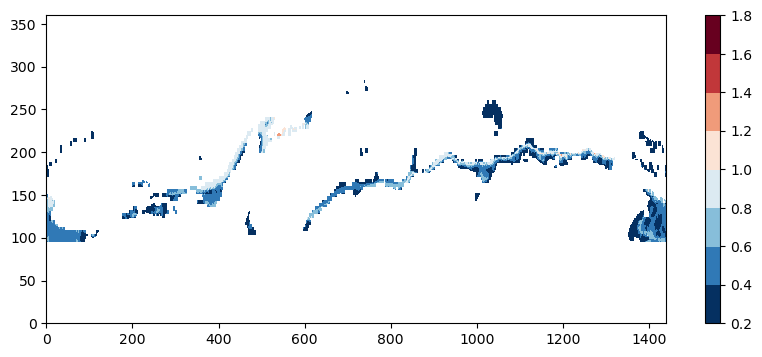

In [21]:

# num_prey_avg_2[:,ss]/num_prey_avg_1[:,ss]

#dd = 25
#print('depth:',depths[dd])
v1,v2 = 0.2,1.8

cmap1 = plt.get_cmap('RdBu_r', 8)

fig = plt.figure(figsize=(10,4))
#plt.pcolor(num_prey2_each_level[dd,:,:]/num_prey1_each_level[dd,:,:],vmin=v1,vmax=v2,cmap=plt.cm.RdBu_r)
plt.pcolor(avg_change_num_prey,vmin=v1,vmax=v2,cmap=cmap1) #plt.cm.RdBu_r)
plt.colorbar()
plt.show()

# use a colorbar with distinct colors:
# 0.2-0.4, 0.4-0.6, 0.6-0.8, 0.8-1, 1-1.2, 1.2-1.4, 1.4-1.6, 1.6-1.8


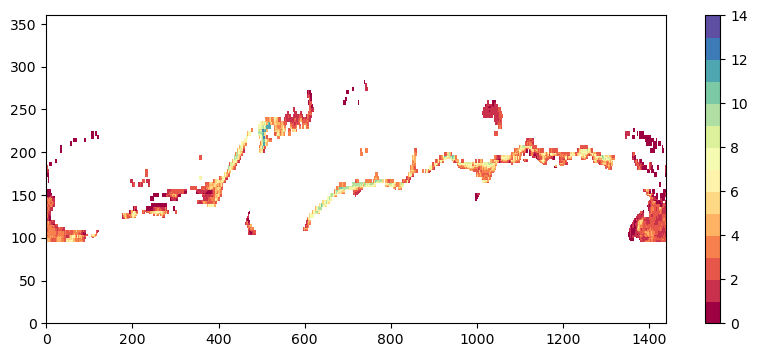

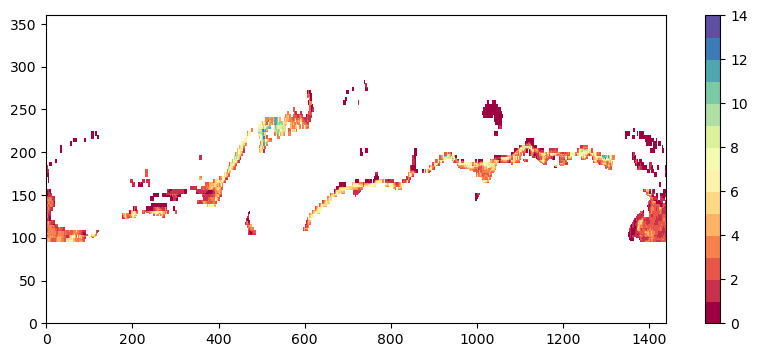

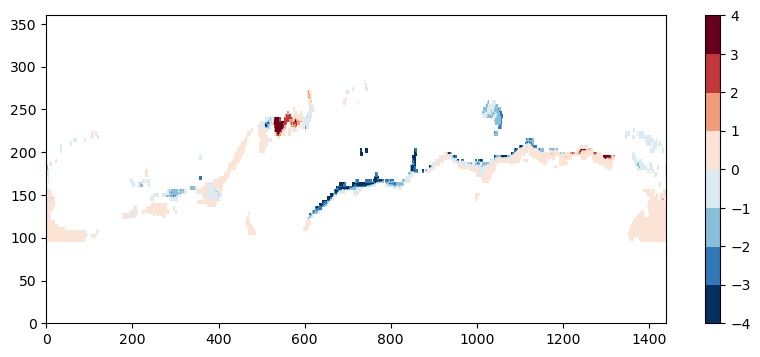

In [22]:

v1,v2 = 0,14
cmap1 = plt.get_cmap('Spectral', v2)

fig = plt.figure(figsize=(10,4))
plt.pcolor(avg_num_prey1,vmin=v1,vmax=v2,cmap=cmap1) #plt.cm.RdBu_r)
plt.colorbar()
plt.show()

fig = plt.figure(figsize=(10,4))
plt.pcolor(avg_num_prey2,vmin=v1,vmax=v2,cmap=cmap1) #plt.cm.RdBu_r)
plt.colorbar()
plt.show()

v1,v2 = -4,4
cmap1 = plt.get_cmap('RdBu_r', v2*2)

fig = plt.figure(figsize=(10,4))
plt.pcolor(avg_num_prey2-avg_num_prey1,vmin=v1,vmax=v2,cmap=cmap1) #plt.cm.RdBu_r)
plt.colorbar()
plt.show()


In [23]:
print(np.max(avg_num_prey1))

12.286086584469748


min/max 0.04495794044744084 12.286086584469748


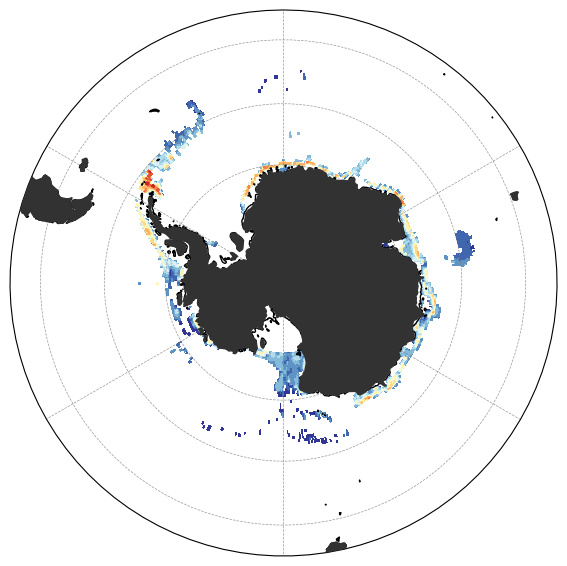

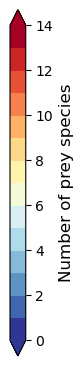

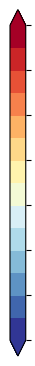

In [24]:
#---
# avg number of prey (averaged over the top 1000m)
#---

levels1 = np.arange(0,14+1,1)
cticks = [0,2,4,6,8,10,12,14]
#cmap1 = ListedColormap(['darkblue','cornflowerblue','mediumturquoise']) # 'dimgrey', #plt.cm.RdYlBu_r
cmap1 = plt.get_cmap('RdYlBu_r', np.max(levels1))

save_plots = True
display_plots = True
dpicnt  = 200

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/AGI_project/number_of_prey_with_drift_corr/v2/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)

lw = 0.8
fs = 12

fig = plt.figure(figsize=(24,18))

projection=ccrs.SouthPolarStereo()    
ax = fig.add_subplot(1, 3, 2, projection=projection)
ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND,facecolor=(50./255.,50./255.,50./255.),zorder=50)  #"grey"
ax.coastlines(resolution='50m')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

data_plot = np.copy(avg_num_prey1)
data_plot = np.ma.masked_where(data_plot==0,data_plot)
#data_plot[np.isinf(data_plot)] = 999
print('min/max',np.min(data_plot),np.max(data_plot))

mm1=ax.contourf(lon,lat, data_plot,levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())    
#cbar = plt.colorbar(mm1,orientation='vertical',fraction=0.075, pad=0.03,shrink=0.25)#,ticks=cticks)
#clabel = 'Number of prey species'
#cbar.set_label(clabel,fontsize=fs)
    
gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels=False
#gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
gl.ylocator = mticker.FixedLocator([-70,-60,-50])
#gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.rotate_labels = False

if save_plots:
    filename = 'Map_prey_number_top_1000m_present-day_'+which_drift+'_2_threshold_'+str(thresh)+'.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
#----
# COLORBAR
#----

fig = plt.figure(figsize=(24,18))
projection=ccrs.SouthPolarStereo()    
ax = fig.add_subplot(1, 3, 2, projection=projection)
data_plot = np.copy(avg_num_prey1)
data_plot = np.ma.masked_where(data_plot==0,data_plot)
mm1=ax.contourf(lon,lat, data_plot,levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())    
plt.gca().set_visible(False)
cbar = plt.colorbar(mm1,orientation='vertical',fraction=0.075, pad=0.03,shrink=0.25,ticks=cticks)
clabel = 'Number of prey species'
cbar.set_label(clabel,fontsize=fs)
if save_plots:
    filename = 'Map_prey_number_top_1000m_present-day_'+which_drift+'_2_threshold_'+str(thresh)+'_COLORBAR.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
fig = plt.figure(figsize=(24,18))
projection=ccrs.SouthPolarStereo()    
ax = fig.add_subplot(1, 3, 2, projection=projection)
data_plot = np.copy(avg_num_prey1)
data_plot = np.ma.masked_where(data_plot==0,data_plot)
mm1=ax.contourf(lon,lat, data_plot,levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())    
plt.gca().set_visible(False)
cbar = plt.colorbar(mm1,orientation='vertical',fraction=0.075, pad=0.03,shrink=0.25,ticks=cticks)
cbar.set_ticklabels([])
if save_plots:
    filename = 'Map_prey_number_top_1000m_present-day_'+which_drift+'_2_threshold_'+str(thresh)+'_COLORBAR.eps'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
if display_plots:
    plt.show()
else:
    plt.close(fig)



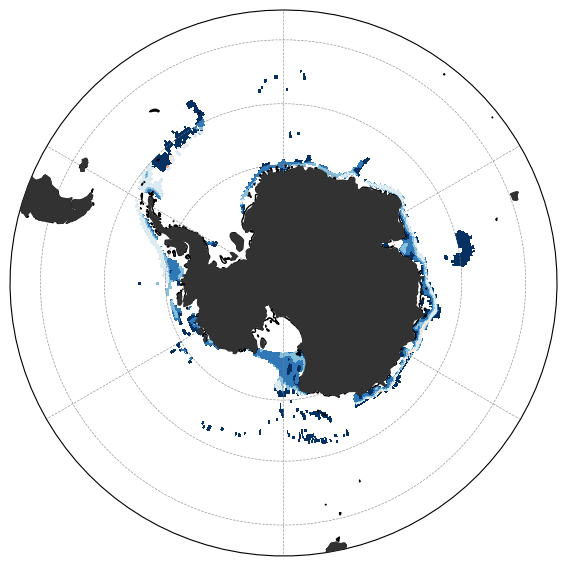

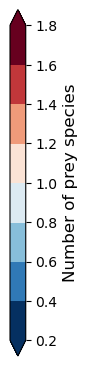

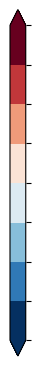

In [25]:
#----
# change in number of prey
#----

save_plots = True
display_plots = True

levels1 = np.arange(0.2,1.8+0.2,0.2)
cticks  = [0.2,0.4,0.6,0.8,1,1.2,1.4,1.6,1.8]
#cmap1 = ListedColormap(['darkblue','cornflowerblue','mediumturquoise']) # 'dimgrey', #plt.cm.RdYlBu_r
cmap1 = plt.get_cmap('RdBu_r', 8)

lw = 0.8
fs = 12

fig = plt.figure(figsize=(24,18))

projection=ccrs.SouthPolarStereo()    
ax = fig.add_subplot(1, 3, 2, projection=projection)
ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND,facecolor=(50./255.,50./255.,50./255.),zorder=50)  #"grey"
ax.coastlines(resolution='50m')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

data_plot = np.copy(avg_change_num_prey)
data_plot[np.isinf(data_plot)] = -999
data_plot = np.ma.masked_where(data_plot==0,data_plot)
#ind_inf = np.where(np.isinf(avg_change_num_prey))[0].shape[0]

mm1=ax.contourf(lon,lat, data_plot,levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())    
    
#cbar = plt.colorbar(mm1,orientation='vertical',fraction=0.075, pad=0.03,shrink=0.25)#,ticks=cticks)
#clabel = '$\Delta$ number of prey species in %'
#cbar.set_label(clabel,fontsize=fs)
gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels=False
#gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
gl.ylocator = mticker.FixedLocator([-70,-60,-50])
#gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.rotate_labels = False

if save_plots:
    filename = 'Map_prey_number_change_top_1000m_change_'+which_sim+'_'+which_drift+'_2_threshold_'+str(thresh)+'.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
    
#----
# COLORBAR
#----

fig = plt.figure(figsize=(24,18))
projection=ccrs.SouthPolarStereo()    
ax = fig.add_subplot(1, 3, 2, projection=projection)
mm1=ax.contourf(lon,lat, data_plot,levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())    
plt.gca().set_visible(False)
cbar = plt.colorbar(mm1,orientation='vertical',fraction=0.075, pad=0.03,shrink=0.25,ticks=cticks)
clabel = 'Number of prey species'
cbar.set_label(clabel,fontsize=fs)
if save_plots:
    filename = 'Map_prey_number_change_top_1000m_change_'+which_sim+'_'+which_drift+'_2_threshold_'+str(thresh)+'_COLORBAR.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='png')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
fig = plt.figure(figsize=(24,18))
projection=ccrs.SouthPolarStereo()    
ax = fig.add_subplot(1, 3, 2, projection=projection)
mm1=ax.contourf(lon,lat, data_plot,levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())    
plt.gca().set_visible(False)
cbar = plt.colorbar(mm1,orientation='vertical',fraction=0.075, pad=0.03,shrink=0.25,ticks=cticks)
cbar.set_ticklabels([])
if save_plots:
    filename = 'Map_prey_number_change_top_1000m_change_'+which_sim+'_'+which_drift+'_2_threshold_'+str(thresh)+'_COLORBAR.eps'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
if display_plots:
    plt.show()
else:
    plt.close(fig)


In [26]:
#---
# plot: average loss of species at each depth level
#---
# separate different sectors of the Southern Ocean


print(num_prey1_each_level.shape,num_prey2_each_level.shape)
print(depths.shape,lat.shape,lon.shape)

#ff = xr.open_dataset('/pscratch/sd/c/cnissen/files_toothfish_project_AGI/Mesh_ancillary_information_v20220725_v2.nc')
ff = xr.open_dataset('/pscratch/sd/c/cnissen/files_toothfish_project_AGI/Mesh_ancillary_information_v20220919.nc') # new path for review process
area  = ff['area'].values 
ff.close()
lon2,lat2 = np.meshgrid(lon,lat)

#---- 
# load masks
ff = xr.open_dataset('/pscratch/sd/c/cnissen/shape_files/ccamlr_areas/CCAMLR_mask_area48_regular_mesh_AGI_mesh.nc')
mask48  = ff['mask_area'].values 
ff.close()
ff = xr.open_dataset('/pscratch/sd/c/cnissen/shape_files/ccamlr_areas/CCAMLR_mask_area58_regular_mesh_AGI_mesh.nc')
mask58  = ff['mask_area'].values 
ff.close()
ff = xr.open_dataset('/pscratch/sd/c/cnissen/shape_files/ccamlr_areas/CCAMLR_mask_area88_regular_mesh_AGI_mesh.nc')
mask88  = ff['mask_area'].values 
ff.close()
#----


print(area.shape,np.sum(area)) # Note: only south of 45°S!

print(np.max(num_prey1_each_level[0,:,:]),max_num_prey[0])
print(np.where(np.asarray(index_min_depth)==0)[0])

#subregions = ['wholeSO','Weddell','eWeddell','Amery','Adelie','Ross','Amundsen']
subregions = ['wholeSO','area48','area58','area88']

num_prey_avg_1 = np.zeros([len(depths),len(subregions)]) # later: expand to different regions
num_prey_avg_2 = np.zeros([len(depths),len(subregions)])
#num_prey_avg_1b = np.zeros([len(depths),len(subregions)])
#num_prey_avg_2b = np.zeros([len(depths),len(subregions)])
for dd in tqdm(range(0,len(depths))):
    # make sure only to include grid cells that are available at current depth
    area2 = np.copy(area)
    area2[pO2_1[dd,:,:].mask==True]=np.nan    
    area2 = area2.ravel()
    # mask of toothfish habitat
    mask = mask_habitat_toothfish_1[dd,:,:].ravel()
    ## mask of toothfish habitat
    #maskb = mask_habitat_toothfish_1b[dd,:,:].ravel()
    
    latlim = -60
    for ss in range(0,len(subregions)):
        if subregions[ss] in ['wholeSO']:
            ind_region = np.where((lat2.ravel()<latlim))[0]
        elif subregions[ss] in ['area48']:
            ind_region = np.where(mask48.ravel()==1)[0]
        elif subregions[ss] in ['area58']:
            ind_region = np.where(mask58.ravel()==1)[0]
        elif subregions[ss] in ['area88']:
            ind_region = np.where(mask88.ravel()==1)[0]
        elif subregions[ss] in ['Amundsen']:
            ind_region = np.where((lat2.ravel()<latlim) & (lon2.ravel()<-60) & (lon2.ravel()>=-120))[0]
        elif subregions[ss] in ['Weddell']:
            ind_region = np.where((lat2.ravel()<latlim) & (lon2.ravel()<-0) & (lon2.ravel()>=-60))[0]
        elif subregions[ss] in ['eWeddell']:
            ind_region = np.where((lat2.ravel()<latlim) & (lon2.ravel()<60) & (lon2.ravel()>=0))[0]
        elif subregions[ss] in ['Amery']:
            ind_region = np.where((lat2.ravel()<latlim) & (lon2.ravel()<120) & (lon2.ravel()>=60))[0]
        elif subregions[ss] in ['Adelie']:
            ind_region = np.where((lat2.ravel()<latlim) & (lon2.ravel()<180) & (lon2.ravel()>=120))[0]
        elif subregions[ss] in ['Ross']:
            ind_region = np.where((lat2.ravel()<latlim) & (lon2.ravel()<-120) & (lon2.ravel()>=-180))[0]
        if dd==0:
            print(subregions[ss],np.nansum(mask[ind_region]*area2[ind_region])/1e12)
        
        num_prey_avg_1[dd,ss] = np.nansum(num_prey1_each_level[dd,:,:].ravel()[ind_region]*mask[ind_region]*area2[ind_region])/np.nansum(mask[ind_region]*area2[ind_region])
        num_prey_avg_2[dd,ss] = np.nansum(num_prey2_each_level[dd,:,:].ravel()[ind_region]*mask[ind_region]*area2[ind_region])/np.nansum(mask[ind_region]*area2[ind_region])
        
        ## simB
        #num_prey_avg_1b[dd,ss] = np.nansum(num_prey1b_each_level[dd,:,:].ravel()[ind_region]*maskb[ind_region]*area2[ind_region])/np.nansum(maskb[ind_region]*area2[ind_region])
        #num_prey_avg_2b[dd,ss] = np.nansum(num_prey2b_each_level[dd,:,:].ravel()[ind_region]*maskb[ind_region]*area2[ind_region])/np.nansum(maskb[ind_region]*area2[ind_region])
    
#fig = plt.figure(figsize=(10,5))
#plt.contourf(lon2,lat2,mask_habitat_toothfish_1[0,:,:])
#plt.show()



(88, 360, 1440) (88, 360, 1440)
(88,) (360,) (1440,)
(360, 1440) 74400100000000.0
6.0 6.0
[ 0 16 17 18 20 23 26]


  6%|▌         | 5/88 [00:00<00:01, 42.57it/s]

wholeSO 2.407584877464
area48 0.683541931768
area58 0.957203688176
area88 0.995956719472


 91%|█████████ | 80/88 [00:01<00:00, 43.87it/s]/tmp/ipykernel_1850360/1974901135.py:77: RuntimeWarning: invalid value encountered in double_scalars
  num_prey_avg_1[dd,ss] = np.nansum(num_prey1_each_level[dd,:,:].ravel()[ind_region]*mask[ind_region]*area2[ind_region])/np.nansum(mask[ind_region]*area2[ind_region])
/tmp/ipykernel_1850360/1974901135.py:78: RuntimeWarning: invalid value encountered in double_scalars
  num_prey_avg_2[dd,ss] = np.nansum(num_prey2_each_level[dd,:,:].ravel()[ind_region]*mask[ind_region]*area2[ind_region])/np.nansum(mask[ind_region]*area2[ind_region])
100%|██████████| 88/88 [00:01<00:00, 44.55it/s]


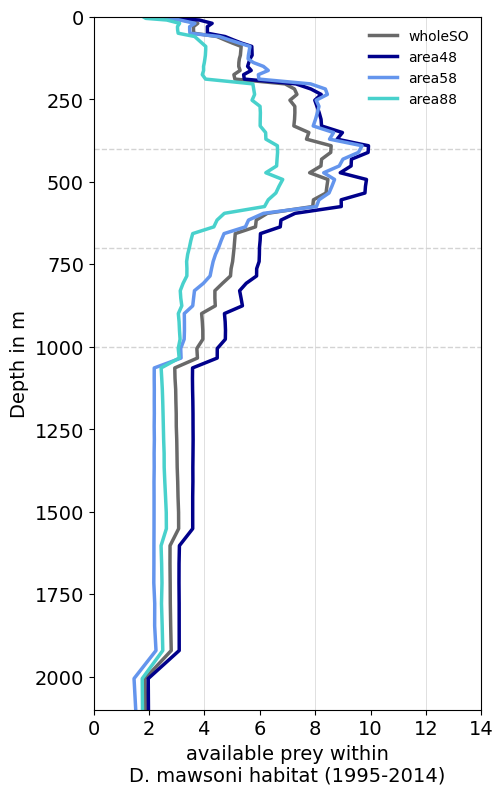

wholeSO 0.8343406300290893
area48 0.8294853094895275
area58 0.779143785328636
area88 0.8658786005688374


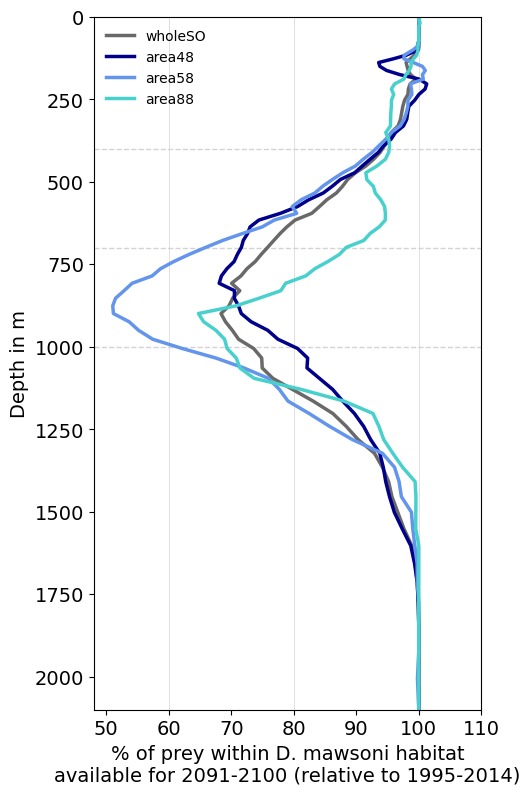

In [27]:
#---
# plot
#---
color_list = ['dimgrey','darkblue','cornflowerblue','mediumturquoise','darkgreen',\
              'grey','firebrick','mediumpurple','darkorange','green','grey']

lw = 2.5
fs = 14
dpicnt = 200

save_plots = False
display_plots = True
plot_eps = False

savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/AGI_project/number_of_prey_with_drift_corr/v2/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    

#---
# present-day prey number
#---
fig = plt.figure(figsize=(5,9))
#plt.vlines(1,0,2100,color='lightgrey',linewidth=1)
plt.vlines(4,0,2100,color='lightgrey',linewidth=0.5)
plt.vlines(8,0,2100,color='lightgrey',linewidth=0.5)
plt.vlines(12,0,2100,color='lightgrey',linewidth=0.5)
plt.hlines(400,0,14,color='lightgrey',linestyle='--',linewidth=1)
plt.hlines(700,0,14,color='lightgrey',linestyle='--',linewidth=1)
plt.hlines(1000,0,14,color='lightgrey',linestyle='--',linewidth=1)
for ss in range(0,len(subregions)):
    plt.plot(num_prey_avg_1[:,ss],depths,color=color_list[ss],linewidth=lw,label=subregions[ss])
plt.ylim((0,2100))
plt.gca().invert_yaxis()
plt.legend(frameon=False)
plt.ylabel('Depth in m',fontsize=fs)
plt.xlabel('available prey within\nD. mawsoni habitat (1995-2014)',fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlim((0,14))
plt.yticks([0,250,500,750,1000,1250,1500,1750,2000],[0,250,500,750,1000,1250,1500,1750,2000],fontsize=fs)
plt.xticks([0,2,4,6,8,10,12,14],[0,2,4,6,8,10,12,14],fontsize=fs)
if save_plots:
    filename = 'Vertical_profile_prey_number_CCAMLR_areas_present_day_2_threshold_'+str(thresh)+'.png'
    #filename = 'Vertical_profile_prey_number_south_of_'+str(-1*latlim)+'S_present_day.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
#---
# future prey loss
#---  
fig = plt.figure(figsize=(5,9))
plt.vlines(1,0,2100,color='lightgrey',linewidth=0.5)
plt.vlines(0.8,0,2100,color='lightgrey',linewidth=0.5)
plt.vlines(0.6,0,2100,color='lightgrey',linewidth=0.5)
plt.hlines(400,0.48,1.1,color='lightgrey',linestyle='--',linewidth=1)
plt.hlines(700,0.48,1.1,color='lightgrey',linestyle='--',linewidth=1)
plt.hlines(1000,0.48,1.1,color='lightgrey',linestyle='--',linewidth=1)
for ss in range(0,len(subregions)):
    ind_dd = 58 # 58=top 1000m
    print(subregions[ss],np.nansum(num_prey_avg_2[1:ind_dd,ss]/num_prey_avg_1[1:ind_dd,ss]*np.diff(depths[0:ind_dd]))/depths[ind_dd])
    plt.plot(num_prey_avg_2[:,ss]/num_prey_avg_1[:,ss],depths,color=color_list[ss],linewidth=lw,label=subregions[ss])
    #plt.plot(num_prey_avg_2b[:,ss]/num_prey_avg_1b[:,ss],depths,color=color_list[ss],linewidth=lw-1,linestyle=':')
    
plt.ylim((0,2100))
plt.gca().invert_yaxis()
plt.legend(frameon=False)
plt.ylabel('Depth in m',fontsize=fs)
plt.xlabel('% of prey within D. mawsoni habitat\navailable for '+\
           str(int(which_drift[0:4]))+'-'+str(int(which_drift[5:]))+' (relative to 1995-2014)',fontsize=fs)
plt.yticks(fontsize=fs)
#plt.xlim((0.65,1.1))
plt.xlim((0.48,1.1))
plt.yticks([0,250,500,750,1000,1250,1500,1750,2000],[0,250,500,750,1000,1250,1500,1750,2000],fontsize=fs)
#plt.xticks([0.7,0.8,0.9,1,1.1],[70,80,90,100,110],fontsize=fs)
plt.xticks([0.5,0.6,0.7,0.8,0.9,1,1.1],[50,60,70,80,90,100,110],fontsize=fs)
#plt.xticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],[20,30,40,50,60,70,80,90,100],fontsize=fs)
if save_plots:
    filename = 'Vertical_profile_prey_loss_CCAMLR_areas_'+which_sim+'_'+which_drift+'_threshold_'+str(thresh)+'.png'
    #filename = 'Vertical_profile_prey_loss_south_of_'+str(-1*latlim)+'S_ssp585.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
    
    
if plot_eps:
    #---
    # present-day prey number
    #---
    fig = plt.figure(figsize=(5,9))
    #plt.vlines(1,0,2100,color='lightgrey',linewidth=1)
    plt.vlines(4,0,2100,color='lightgrey',linewidth=0.5)
    plt.vlines(8,0,2100,color='lightgrey',linewidth=0.5)
    plt.vlines(12,0,2100,color='lightgrey',linewidth=0.5)
    plt.hlines(400,0,14,color='lightgrey',linestyle='--',linewidth=1)
    plt.hlines(700,0,14,color='lightgrey',linestyle='--',linewidth=1)
    plt.hlines(1000,0,14,color='lightgrey',linestyle='--',linewidth=1)
    for ss in range(0,len(subregions)):
        plt.plot(num_prey_avg_1[:,ss],depths,color=color_list[ss],linewidth=lw,label=subregions[ss])
    plt.ylim((0,2100))
    plt.gca().invert_yaxis()
    plt.legend(frameon=False)
    #plt.ylabel('Depth in m',fontsize=fs)
    #plt.xlabel('available prey within\nD. mawsoni habitat (1995-2014)',fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlim((0,14))
    plt.yticks([0,250,500,750,1000,1250,1500,1750,2000],[],fontsize=fs)
    plt.xticks([0,2,4,6,8,10,12,14],[],fontsize=fs)
    if save_plots:
        filename = 'Vertical_profile_prey_number_CCAMLR_areas_present_day_2_threshold_'+str(thresh)+'.eps'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    #---
    # future prey loss
    #---  
    fig = plt.figure(figsize=(5,9))
    plt.vlines(1,0,2100,color='lightgrey',linewidth=0.5)
    plt.vlines(0.8,0,2100,color='lightgrey',linewidth=0.5)
    plt.vlines(0.6,0,2100,color='lightgrey',linewidth=0.5)
    plt.hlines(400,0.48,1.1,color='lightgrey',linestyle='--',linewidth=1)
    plt.hlines(700,0.48,1.1,color='lightgrey',linestyle='--',linewidth=1)
    plt.hlines(1000,0.48,1.1,color='lightgrey',linestyle='--',linewidth=1)
    for ss in range(0,len(subregions)):
        plt.plot(num_prey_avg_2[:,ss]/num_prey_avg_1[:,ss],depths,color=color_list[ss],linewidth=lw,label=subregions[ss])
        #plt.plot(num_prey_avg_2b[:,ss]/num_prey_avg_1b[:,ss],depths,color=color_list[ss],linewidth=lw-1,linestyle=':')
    plt.ylim((0,2100))
    plt.gca().invert_yaxis()
    plt.legend(frameon=False)
    #plt.ylabel('Depth in m',fontsize=fs)
    #plt.xlabel('% of prey within D. mawsoni habitat\navailable for 2090s (relative to 1995-2014)',fontsize=fs)
    plt.yticks(fontsize=fs)
    #plt.xlim((0.65,1.1))
    plt.xlim((0.48,1.1))
    plt.yticks([0,250,500,750,1000,1250,1500,1750,2000],[0,250,500,750,1000,1250,1500,1750,2000],fontsize=fs)
    #plt.xticks([0.7,0.8,0.9,1,1.1],[70,80,90,100,110],fontsize=fs)
    plt.xticks([0.5,0.6,0.7,0.8,0.9,1,1.1],[],fontsize=fs)
    if save_plots:
        filename = 'Vertical_profile_prey_loss_CCAMLR_areas_'+which_sim+'_'+which_drift+'_2_threshold_'+str(thresh)+'.eps'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
    


In [ ]:
print(which_sim)

In [ ]:
#---
# plot map of subareas
#---
import cartopy.crs as ccrs
import cartopy
from cartopy.util import add_cyclic_point
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import matplotlib.path as mpath
import copy
from matplotlib import colors
import seaborn as sns
from matplotlib.colors import ListedColormap

mask_all = np.zeros_like(mask48)
mask_all[mask48==1]=1
mask_all[mask58==1]=2
mask_all[mask88==1]=3
mask_all = np.ma.masked_where(mask_all==0,mask_all)

levels1 = np.arange(0,3+1,1)
lw = 0.8
cmap1 = ListedColormap(['darkblue','cornflowerblue','mediumturquoise']) # 'dimgrey', #plt.cm.RdYlBu_r

fig = plt.figure(figsize=(24,18))

projection=ccrs.SouthPolarStereo()    
ax = fig.add_subplot(1, 3, 2, projection=projection)
ax.set_extent([-280, 80, -80, -45], crs=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND,facecolor=(50./255.,50./255.,50./255.),zorder=50)  #"grey"
ax.coastlines(resolution='50m')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
    
mm1=ax.contourf(lon,lat, mask_all,levels=levels1,extend='both',cmap=cmap1,transform=ccrs.PlateCarree())    
    
#cbar = plt.colorbar(mm1,orientation='vertical',fraction=0.075, pad=0.03,shrink=0.25)#,ticks=cticks)
#cbar.set_label(clabel,fontsize=fs)
    
# toothfish habitat
ind_tf = species_names.index('Dissostichus mawsoni')
mm1=ax.contour(lon,lat, habitat_all[:,:,ind_tf],levels=[1],colors=['bisque'],linewidths=[lw],linestyles=['-'],\
                   transform=ccrs.PlateCarree())   
    
gl=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=.5,\
                color='grey', alpha=0.8,linestyle='--')#,xlabels_bottom=True)
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = False
gl.right_labels=False
#gl.xlines = True
gl.xlocator = mticker.FixedLocator([-180,-120,-60,0,60,120]) 
gl.ylocator = mticker.FixedLocator([-70,-60,-50])
#gl.ylocator = LatitudeLocator()
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.rotate_labels = False
    
if save_plots:
    filename = 'Map_CCAMLR_areas_threshold_'+str(thresh)+'.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
plt.show()
